Explor the Relationship between Player Performance and Match Outcomes in Dota 2

Author: Qichang Dong
Description:
    This project aims to investigate the relationship between player performance and match outcomes in Dota 2, a popular MOBA game. The project utilizes a dataset of game features and outcomes, including player statistics, game duration, and match results. Through exploratory data analysis and statistical modeling, the project seeks to identify key factors that contribute to winning or losing a match and to develop predictive models that can accurately forecast match outcomes based on player performance. The insights gained from this project can provide valuable information to players and teams looking to improve their gameplay and increase their chances of winning matches.

Import Required Elements

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import json



Read all required Datasets

In [2]:
train = pd.read_csv('train_features.csv', index_col='match_id_hash')
target = pd.read_csv('train_targets.csv', index_col='match_id_hash')
test = pd.read_csv('test_features.csv', index_col='match_id_hash')
sample_submission = pd.read_csv('sample_submission.csv')
submission = pd.read_csv('submission.csv')

Explor Datasets and drop some duplicate columns

In [3]:
print(train.columns)
print(target.columns)
# Drop few columns that are duplicate within the target
target = target.drop(columns=['game_time','duration','time_remaining','next_roshan_team',])
print(target.columns)


Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies',
       ...
       'd5_stuns', 'd5_creeps_stacked', 'd5_camps_stacked', 'd5_rune_pickups',
       'd5_firstblood_claimed', 'd5_teamfight_participation',
       'd5_towers_killed', 'd5_roshans_killed', 'd5_obs_placed',
       'd5_sen_placed'],
      dtype='object', length=245)
Index(['game_time', 'radiant_win', 'duration', 'time_remaining',
       'next_roshan_team'],
      dtype='object')
Index(['radiant_win'], dtype='object')


In [4]:
# Merge the target data with train_data
train_data = train.merge(target, on='match_id_hash')

# Extract features and target from the train data
X = train_data.drop(columns='radiant_win')
y = train_data['radiant_win']
# Convert non-numeric values to numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
with open('train_matches.jsonl') as fin:
    # read the 18-th line
    for i in range(18):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

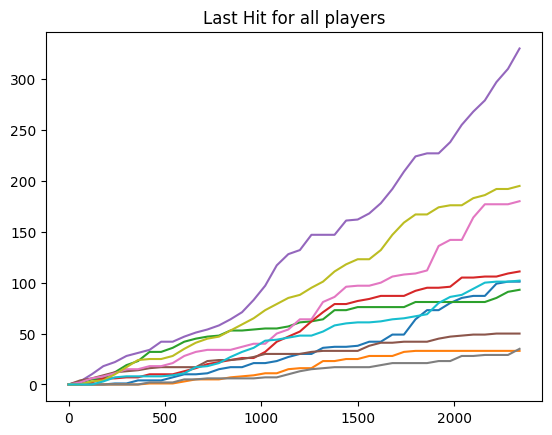

In [6]:
player = match['players'][2]
player['kills'], player['deaths'], player['assists']
for player in match['players']:
    plt.plot(player['times'], player['lh_t'])
plt.title('Last Hit for all players');

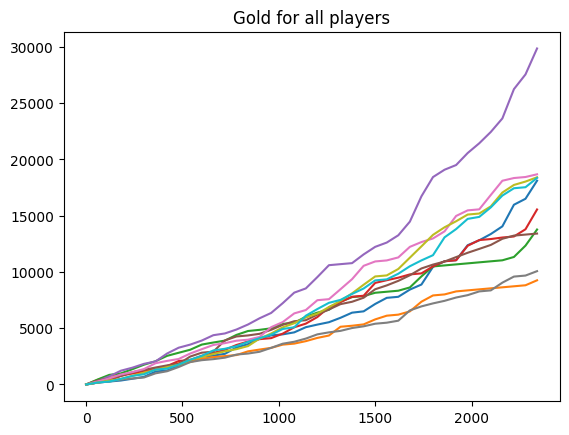

In [7]:
for player in match['players']:
    plt.plot(player['times'], player['gold_t'])
plt.title('Gold for all players');

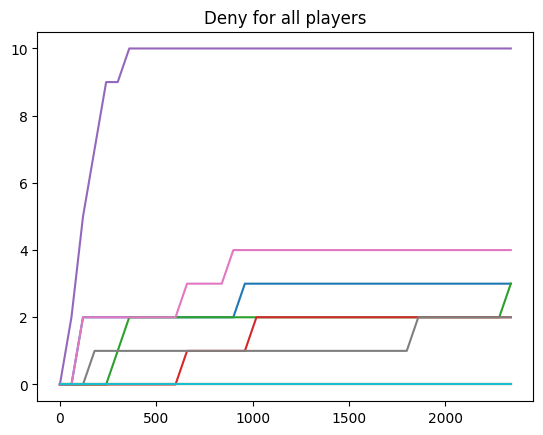

In [8]:
for player in match['players']:
    plt.plot(player['times'], player['dn_t'])
plt.title('Deny for all players');

In [9]:
# Create a logistic regression model
model = LogisticRegression(random_state=42,max_iter=1000)

# Train the model
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [10]:
# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate the accuracy and ROC AUC score
accuracy = accuracy_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


Accuracy: 0.7241
ROC AUC Score: 0.7217


In [11]:
# Extract the features from the test data
print(test.columns)
X_test = test
X_test = scaler.transform(X_test)

# Make predictions on the test set
test_preds = model.predict_proba(X_test)[:, 1]



Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies',
       ...
       'd5_stuns', 'd5_creeps_stacked', 'd5_camps_stacked', 'd5_rune_pickups',
       'd5_firstblood_claimed', 'd5_teamfight_participation',
       'd5_towers_killed', 'd5_roshans_killed', 'd5_obs_placed',
       'd5_sen_placed'],
      dtype='object', length=245)


Produce Output

In [12]:
submission['match_id_hash'] = sample_submission['match_id_hash']
submission['radiant_win_prob'] = test_preds
submission.to_csv('submission.csv', index=False)
